In [3]:
#%pip install -U sentence-transformers gensim transformers tqdm -q
#%pip install click --upgrade

import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import sklearn
import sys
sys.setrecursionlimit(10000)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import json
import torch
import re
import nltk
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split, GridSearchCV
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import AdaBoostClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from xgboost import XGBClassifier
from tqdm import tqdm
tqdm.pandas()
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
"""
nltk.download('punkt')scv
nltk.download('stopwords')
nltk.download('wordnet')

"""

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


"\nnltk.download('punkt')scv\nnltk.download('stopwords')\nnltk.download('wordnet')\n\n"

## Loading the dataset

In [5]:
# Load dataset.
stocknews_df_org = pd.read_excel("datasets_final/KZ/kase_stock_news.xlsx")
stocknews_df = stocknews_df_org.copy()
stocknews_df.shape

(1270, 9)

In [6]:
stocknews_df[["Date", "Ticker", "Open","Close", "High", "Low", "Volume"]].sample(n=5)

,Date,Ticker,Open,Close,High,Low,Volume
384,24.08.21,KASE,3032.86,3038.25,3071.95,3026.34,946230000.0
717,30.12.22,KASE,3232.24,3240.46,3244.40,3227.09,154690000.0
234,13.01.21,KASE,2793.58,2812.93,2818.66,2778.36,74090000.0
814,29.05.23,KASE,3586.85,3585.18,3646.98,3560.86,595680000.0
613,03.08.22,KASE,2968.81,2949.41,2971.01,2932.51,97150000.0


In [7]:
stocknews_df[["Date", "Ticker", "News","Label"]].sample(n=5)

,Date,Ticker,News,Label
839,03.07.23,KASE,The introduction of private placement as a too...,1
501,16.02.22,KASE,The January events affected Kazakhstan’s stock...,0
631,27.08.22,KASE,Geopolitical turbulence led to a 27.2% drop in...,0
449,24.11.21,KASE,Kazakhstan Stock Exchange (KASE) returned to g...,1
935,20.11.23,KASE,"The Clearing Center of KASE, which handles all...",1


# System Code

# 1) BERT Model (Natural Language Processing model)

модель для обработки, анализа текста

### KASE

In [19]:
# читаем файл с датасетом (цены акций + новости)
df = pd.read_excel("datasets_final/KZ/kase_stock_news.xlsx")

# на всякий случай преобразуем столбец с новостями в строки и удаляем пробелы в начале и конце строки
df['News'] = df['News'].astype(str).str.strip()

# если метки (Label) имеют значения -1, 0, 1, преобразуем их в 0, 1, 2
label_map = {-1: 0, 0: 1, 1: 2}
df['Label'] = df['Label'].map(label_map)

# делим датасет на трейн и тест сеты для ml model
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

train_df.head()

,Date,Ticker,News,Label,Open,High,Low,Close,Volume
409,29.10.15,KASE,“We provided the market with additional inform...,1,881.75,884.79,878.32,881.82,80.90
1205,29.01.19,KASE,"In an interview on Egemen Qazaqstan, Alina Ald...",2,2267.95,2291.31,2260.03,2266.39,138.01
775,28.04.17,KASE,The Kursiv research article presents an overvi...,1,1542.58,1553.36,1542.36,1546.59,230.84
1199,21.01.19,KASE,"In an interview on Egemen Qazaqstan, Alina Ald...",2,2322.66,2332.59,2288.97,2292.79,96.12
1358,12.09.19,KASE,Kairat Turmagambetov reports that the class of...,2,2176.49,2195.40,2176.49,2189.42,90.41


In [21]:
# создаем новый класс для датасета для подготовки данных к обучению модели 
# нужен для удобной и правильной подачи текстовых данных в модель BERT в PyTorch.

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist() # определение списка новостей
        self.labels = labels.tolist() # список меток (категории) 
        self.tokenizer = tokenizer # токенизатор - используется чтобы превратить текст в формат, понятный для модели
        self.max_length = max_length  # макс длина токена

    def __len__(self):
        return len(self.texts) 

    # токенизируем текст
    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True, # указывает какие токены настоящие
            return_tensors='pt'
        )
        # Убираем лишнее измерение (batch размер 1)
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Токенизатор - это как "переводчик", который превращает обычный текст (например, "Breaking news in tech...") в цифры, которые может понимать модель.
# BERT - популярная нейросеть для понимания текста. bert-base-uncased - предварительно обученая версия BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# передаем трейн и тест в класс NewsDataset
train_dataset = NewsDataset(train_df['News'], train_df['Label'], tokenizer, max_length=128)
test_dataset = NewsDataset(test_df['News'], test_df['Label'], tokenizer, max_length=128)

num_labels = 3  # три класса 0, 1, 2

#создаем модель BERT, которая уже знает английский. Она будет понимать текст и классифицировать его по трем категориям
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)


# функция для оценки насколько хорошо работает модель
def compute_metrics(eval_pred):
    
    logits, labels = eval_pred # предсказания модели (logits) и настоящие метки (labels)
    predictions = np.argmax(logits, axis=-1) # предсказанная моделью категория
    
    # метрики — показатели качества:
    acc = accuracy_score(labels, predictions) 
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# как будет происходить обучение
training_args = TrainingArguments(
    output_dir='./results', # где будут сохранятся результаты
    num_train_epochs=3,              # сколько раз модель просмотрит данные
    per_device_train_batch_size=16,  # Размер "порций" данных, которые обрабатываются за один раз (batch size)
    per_device_eval_batch_size=16,  
    evaluation_strategy="epoch",     # Модель будет оцениваться после каждой эпохи
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch', # Сохранять модель после каждой эпохи
    load_best_model_at_end=True,
    metric_for_best_model='accuracy' # В конце обучения будет автоматически загружена лучшая версия модели по accuracy
)

# создаем объект для запуска обучения, оценивания модели
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


# запуск обучения модели
"""Модель начнёт просматривать данные, сравнивать предсказания с правильными метками, 
и настраивать себя, чтобы ошибаться меньше."""
trainer.train() 

# оцениваем модель
eval_results = trainer.evaluate()
print(eval_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.037500,0.028014,0.990758,0.990683,0.990832,0.990758
2,0.000800,0.012439,0.998152,0.998145,0.998170,0.998152
3,0.000700,0.012767,0.998152,0.998145,0.998170,0.998152


{'eval_loss': 0.012439180165529251, 'eval_accuracy': 0.9981515711645101, 'eval_f1': 0.9981451274947883, 'eval_precision': 0.9981702421628486, 'eval_recall': 0.9981515711645101, 'eval_runtime': 51.6507, 'eval_samples_per_second': 10.474, 'eval_steps_per_second': 0.658, 'epoch': 3.0}


In [23]:
# checking on single sample
sample_text = test_df['News'].iloc[4]
print("Исходный текст:", sample_text)

encoding = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=128,
    truncation=True,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
)

model.eval()
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=1).item()

print("Predicted label:", predicted_class)
print("Actual label:", test_df['Label'].iloc[0])

Исходный текст: Kazakhstan Stock Exchange (KASE) returned to growth after the pandemic. The trading volume for 7 months reached 83.5 trillion tenge, an increase of 19.1%. The KASE index grew by 15.4%, the share market capitalization rose by 48.2%.
Predicted label: 2
Actual label: 2


### HSBK

In [33]:
# читаем файл с датасетом (цены акций + новости)
df = pd.read_excel("datasets_final/KZ/HSBK_stock_news.xlsx")

# на всякий случай преобразуем столбец с новостями в строки и удаляем пробелы в начале и конце строки
df['News'] = df['News'].astype(str).str.strip()

# если метки (Label) имеют значения -1, 0, 1, преобразуем их в 0, 1, 2
label_map = {-1: 0, 0: 1, 1: 2}
df['Label'] = df['Label'].map(label_map)

# делим датасет на трейн и тест сеты для ml model
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

train_df.head()

,Date,Ticker,News,Label,Open,High,Low,Close,Vol
1234,21.02.2025,HSBK,Bank CenterCredit has won the Best Sustainabil...,2,260.02,261.73,259.02,260.59,25457000
123,22.07.2020,HSBK,Bank CenterCredit became the winner of the ann...,2,117.00,117.05,113.70,116.08,20230000
946,05.12.2023,HSBK,Bank CenterCredit acquired a controlling stake...,1,158.90,159.48,158.01,159.00,29011000
221,21.12.2020,HSBK,According to analysts from international ratin...,1,122.02,122.99,118.65,119.99,13590000
784,10.04.2023,HSBK,Bank CenterCredit launches a new premium card ...,2,151.97,152.58,150.27,151.02,38528000


In [35]:
# создаем новый класс для датасета для подготовки данных к обучению модели 
# нужен для удобной и правильной подачи текстовых данных в модель BERT в PyTorch.

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist() # определение списка новостей
        self.labels = labels.tolist() # список меток (категории) 
        self.tokenizer = tokenizer # токенизатор - используется чтобы превратить текст в формат, понятный для модели
        self.max_length = max_length  # макс длина токена

    def __len__(self):
        return len(self.texts) 

    # токенизируем текст
    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True, # указывает какие токены настоящие
            return_tensors='pt'
        )
        # Убираем лишнее измерение (batch размер 1)
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Токенизатор - это как "переводчик", который превращает обычный текст (например, "Breaking news in tech...") в цифры, которые может понимать модель.
# BERT - популярная нейросеть для понимания текста. bert-base-uncased - предварительно обученая версия BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# передаем трейн и тест в класс NewsDataset
train_dataset = NewsDataset(train_df['News'], train_df['Label'], tokenizer, max_length=128)
test_dataset = NewsDataset(test_df['News'], test_df['Label'], tokenizer, max_length=128)

num_labels = 3  # три класса 0, 1, 2

#создаем модель BERT, которая уже знает английский. Она будет понимать текст и классифицировать его по трем категориям
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)


# функция для оценки насколько хорошо работает модель
def compute_metrics(eval_pred):
    
    logits, labels = eval_pred # предсказания модели (logits) и настоящие метки (labels)
    predictions = np.argmax(logits, axis=-1) # предсказанная моделью категория
    
    # метрики — показатели качества:
    acc = accuracy_score(labels, predictions) 
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# как будет происходить обучение
training_args = TrainingArguments(
    output_dir='./results', # где будут сохранятся результаты
    num_train_epochs=3,              # сколько раз модель просмотрит данные
    per_device_train_batch_size=16,  # Размер "порций" данных, которые обрабатываются за один раз (batch size)
    per_device_eval_batch_size=16,  
    evaluation_strategy="epoch",     # Модель будет оцениваться после каждой эпохи
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch', # Сохранять модель после каждой эпохи
    load_best_model_at_end=True,
    metric_for_best_model='accuracy' # В конце обучения будет автоматически загружена лучшая версия модели по accuracy
)

# создаем объект для запуска обучения, оценивания модели
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


# запуск обучения модели
"""Модель начнёт просматривать данные, сравнивать предсказания с правильными метками, 
и настраивать себя, чтобы ошибаться меньше."""
trainer.train() 

# оцениваем модель
eval_results = trainer.evaluate()
print(eval_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.129700,0.142613,0.968504,0.962795,0.957178,0.968504
2,0.040100,0.054182,0.988189,0.987863,0.988554,0.988189
3,0.003500,0.010410,0.996063,0.996067,0.996104,0.996063


{'eval_loss': 0.01041044294834137, 'eval_accuracy': 0.9960629921259843, 'eval_f1': 0.9960671183407718, 'eval_precision': 0.9961044343141319, 'eval_recall': 0.9960629921259843, 'eval_runtime': 26.9179, 'eval_samples_per_second': 9.436, 'eval_steps_per_second': 0.594, 'epoch': 3.0}


### KSPI

In [40]:
# читаем файл с датасетом (цены акций + новости)
df = pd.read_excel("datasets_final/KZ/KSPI_stock_news.xlsx")

# на всякий случай преобразуем столбец с новостями в строки и удаляем пробелы в начале и конце строки
df['News'] = df['News'].astype(str).str.strip()

# если метки (Label) имеют значения -1, 0, 1, преобразуем их в 0, 1, 2
label_map = {-1: 0, 0: 1, 1: 2}
df['Label'] = df['Label'].map(label_map)

# делим датасет на трейн и тест сеты для ml model
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

train_df.head()

,Date,Ticker,News,Label,Close,Open,High,Low,Vol
728,05.07.2024,KSPI,The international rating agency S&P Global Rat...,2,"64,850.00","64,510.00","64,998.00","64,492.64",112000
132,03.02.2022,KSPI,By the decree of the President of the Republic...,2,"41,040.00","39,950.00","41,096.00","39,950.00",40000
544,06.10.2023,KSPI,The annual Kazakhstan Growth Forum hosted a tr...,2,"45,399.50","45,349.00","45,399.50","44,901.00",24000
517,29.08.2023,KSPI,At an extraordinary general meeting of shareho...,1,"46,155.00","45,769.00","46,155.00","45,769.00",53000
266,22.08.2022,KSPI,"In June 2022, the trading volume on Astana Int...",1,"26,150.00","26,764.90","26,764.90","26,150.00",61000


In [42]:
# создаем новый класс для датасета для подготовки данных к обучению модели 
# нужен для удобной и правильной подачи текстовых данных в модель BERT в PyTorch.

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist() # определение списка новостей
        self.labels = labels.tolist() # список меток (категории) 
        self.tokenizer = tokenizer # токенизатор - используется чтобы превратить текст в формат, понятный для модели
        self.max_length = max_length  # макс длина токена

    def __len__(self):
        return len(self.texts) 

    # токенизируем текст
    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True, # указывает какие токены настоящие
            return_tensors='pt'
        )
        # Убираем лишнее измерение (batch размер 1)
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Токенизатор - это как "переводчик", который превращает обычный текст (например, "Breaking news in tech...") в цифры, которые может понимать модель.
# BERT - популярная нейросеть для понимания текста. bert-base-uncased - предварительно обученая версия BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# передаем трейн и тест в класс NewsDataset
train_dataset = NewsDataset(train_df['News'], train_df['Label'], tokenizer, max_length=128)
test_dataset = NewsDataset(test_df['News'], test_df['Label'], tokenizer, max_length=128)

num_labels = 3  # три класса 0, 1, 2

#создаем модель BERT, которая уже знает английский. Она будет понимать текст и классифицировать его по трем категориям
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)


# функция для оценки насколько хорошо работает модель
def compute_metrics(eval_pred):
    
    logits, labels = eval_pred # предсказания модели (logits) и настоящие метки (labels)
    predictions = np.argmax(logits, axis=-1) # предсказанная моделью категория
    
    # метрики — показатели качества:
    acc = accuracy_score(labels, predictions) 
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# как будет происходить обучение
training_args = TrainingArguments(
    output_dir='./results', # где будут сохранятся результаты
    num_train_epochs=3,              # сколько раз модель просмотрит данные
    per_device_train_batch_size=16,  # Размер "порций" данных, которые обрабатываются за один раз (batch size)
    per_device_eval_batch_size=16,  
    evaluation_strategy="epoch",     # Модель будет оцениваться после каждой эпохи
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch', # Сохранять модель после каждой эпохи
    load_best_model_at_end=True,
    metric_for_best_model='accuracy' # В конце обучения будет автоматически загружена лучшая версия модели по accuracy
)

# создаем объект для запуска обучения, оценивания модели
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


# запуск обучения модели
"""Модель начнёт просматривать данные, сравнивать предсказания с правильными метками, 
и настраивать себя, чтобы ошибаться меньше."""
trainer.train() 

# оцениваем модель
eval_results = trainer.evaluate()
print(eval_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.070700,0.038288,0.988950,0.988972,0.989241,0.988950
2,0.043000,0.004271,1.000000,1.000000,1.000000,1.000000
3,0.003200,0.002698,1.000000,1.000000,1.000000,1.000000


{'eval_loss': 0.00427093543112278, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 19.5348, 'eval_samples_per_second': 9.266, 'eval_steps_per_second': 0.614, 'epoch': 3.0}


### KZAP

In [45]:
# читаем файл с датасетом (цены акций + новости)
df = pd.read_excel("datasets_final/KZ/KZAP_stock_news.xlsx")

# на всякий случай преобразуем столбец с новостями в строки и удаляем пробелы в начале и конце строки
df['News'] = df['News'].astype(str).str.strip()

# если метки (Label) имеют значения -1, 0, 1, преобразуем их в 0, 1, 2
label_map = {-1: 0, 0: 1, 1: 2}
df['Label'] = df['Label'].map(label_map)

# делим датасет на трейн и тест сеты для ml model
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

train_df.head()

,Date,Ticker,News,Label,Close,Open,High,Low,Vol
483,21.01.2022,KZAP,The National Atomic Company Kazatomprom has si...,1,15780.00,16295.00,16295.00,15410.00,63000
733,27.01.2023,KZAP,JSC NAC Kazatomprom has redeemed short-term bo...,1,14130.00,14330.00,14330.00,14050.00,421000
619,12.08.2022,KZAP,Kazatomprom is monitoring the situation with s...,1,13768.88,13863.66,13863.66,13650.00,103000
480,18.01.2022,KZAP,The National Atomic Company Kazatomprom has si...,1,15680.00,16102.00,16149.99,15350.00,114000
141,24.08.2020,KZAP,National Atomic Company Kazatomprom has extend...,1,6068.99,6005.00,6068.99,5708.01,11000


In [47]:
# создаем новый класс для датасета для подготовки данных к обучению модели 
# нужен для удобной и правильной подачи текстовых данных в модель BERT в PyTorch.

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist() # определение списка новостей
        self.labels = labels.tolist() # список меток (категории) 
        self.tokenizer = tokenizer # токенизатор - используется чтобы превратить текст в формат, понятный для модели
        self.max_length = max_length  # макс длина токена

    def __len__(self):
        return len(self.texts) 

    # токенизируем текст
    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True, # указывает какие токены настоящие
            return_tensors='pt'
        )
        # Убираем лишнее измерение (batch размер 1)
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Токенизатор - это как "переводчик", который превращает обычный текст (например, "Breaking news in tech...") в цифры, которые может понимать модель.
# BERT - популярная нейросеть для понимания текста. bert-base-uncased - предварительно обученая версия BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# передаем трейн и тест в класс NewsDataset
train_dataset = NewsDataset(train_df['News'], train_df['Label'], tokenizer, max_length=128)
test_dataset = NewsDataset(test_df['News'], test_df['Label'], tokenizer, max_length=128)

num_labels = 3  # три класса 0, 1, 2

#создаем модель BERT, которая уже знает английский. Она будет понимать текст и классифицировать его по трем категориям
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)


# функция для оценки насколько хорошо работает модель
def compute_metrics(eval_pred):
    
    logits, labels = eval_pred # предсказания модели (logits) и настоящие метки (labels)
    predictions = np.argmax(logits, axis=-1) # предсказанная моделью категория
    
    # метрики — показатели качества:
    acc = accuracy_score(labels, predictions) 
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# как будет происходить обучение
training_args = TrainingArguments(
    output_dir='./results', # где будут сохранятся результаты
    num_train_epochs=3,              # сколько раз модель просмотрит данные
    per_device_train_batch_size=16,  # Размер "порций" данных, которые обрабатываются за один раз (batch size)
    per_device_eval_batch_size=16,  
    evaluation_strategy="epoch",     # Модель будет оцениваться после каждой эпохи
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch', # Сохранять модель после каждой эпохи
    load_best_model_at_end=True,
    metric_for_best_model='accuracy' # В конце обучения будет автоматически загружена лучшая версия модели по accuracy
)

# создаем объект для запуска обучения, оценивания модели
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


# запуск обучения модели
"""Модель начнёт просматривать данные, сравнивать предсказания с правильными метками, 
и настраивать себя, чтобы ошибаться меньше."""
trainer.train() 

# оцениваем модель
eval_results = trainer.evaluate()
print(eval_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.102200,0.035109,0.996047,0.996040,0.996070,0.996047
2,0.047600,0.004046,1.000000,1.000000,1.000000,1.000000
3,0.001800,0.022416,0.996047,0.996040,0.996070,0.996047


{'eval_loss': 0.004046340472996235, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 28.7314, 'eval_samples_per_second': 8.806, 'eval_steps_per_second': 0.557, 'epoch': 3.0}


### KEGC

In [50]:
# читаем файл с датасетом (цены акций + новости)
df = pd.read_excel("datasets_final/KZ/KEGC_stock_news.xlsx")

# на всякий случай преобразуем столбец с новостями в строки и удаляем пробелы в начале и конце строки
df['News'] = df['News'].astype(str).str.strip()

# если метки (Label) имеют значения -1, 0, 1, преобразуем их в 0, 1, 2
label_map = {-1: 0, 0: 1, 1: 2}
df['Label'] = df['Label'].map(label_map)

# делим датасет на трейн и тест сеты для ml model
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

train_df.head()

,Date,Ticker,News,Label,Close,Open,High,Low,Volume
155,14.09.2020,KEGC,Kazakhstan brokers estimate one share of KEGOC...,1,1703.01,1716.93,1716.93,1700.0,441000
282,19.03.2021,KEGC,One of the most important factors in increasin...,2,1662.00,1663.90,1668.00,1662.0,717000
565,24.05.2022,KEGC,Market review prepared by analysts of the Asso...,1,1660.00,1668.00,1668.00,1657.0,28000
107,03.07.2020,KEGC,Kazakhstan brokers estimate one share of KEGOC...,1,1710.00,1710.00,1710.00,1705.0,45000
777,31.03.2023,KEGC,Power outages in six regions of Kazakhstan wer...,1,1618.02,1602.02,1618.02,1602.0,361000


In [52]:
# создаем новый класс для датасета для подготовки данных к обучению модели 
# нужен для удобной и правильной подачи текстовых данных в модель BERT в PyTorch.

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist() # определение списка новостей
        self.labels = labels.tolist() # список меток (категории) 
        self.tokenizer = tokenizer # токенизатор - используется чтобы превратить текст в формат, понятный для модели
        self.max_length = max_length  # макс длина токена

    def __len__(self):
        return len(self.texts) 

    # токенизируем текст
    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True, # указывает какие токены настоящие
            return_tensors='pt'
        )
        # Убираем лишнее измерение (batch размер 1)
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Токенизатор - это как "переводчик", который превращает обычный текст (например, "Breaking news in tech...") в цифры, которые может понимать модель.
# BERT - популярная нейросеть для понимания текста. bert-base-uncased - предварительно обученая версия BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# передаем трейн и тест в класс NewsDataset
train_dataset = NewsDataset(train_df['News'], train_df['Label'], tokenizer, max_length=128)
test_dataset = NewsDataset(test_df['News'], test_df['Label'], tokenizer, max_length=128)

num_labels = 3  # три класса 0, 1, 2

#создаем модель BERT, которая уже знает английский. Она будет понимать текст и классифицировать его по трем категориям
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)


# функция для оценки насколько хорошо работает модель
def compute_metrics(eval_pred):
    
    logits, labels = eval_pred # предсказания модели (logits) и настоящие метки (labels)
    predictions = np.argmax(logits, axis=-1) # предсказанная моделью категория
    
    # метрики — показатели качества:
    acc = accuracy_score(labels, predictions) 
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# как будет происходить обучение
training_args = TrainingArguments(
    output_dir='./results', # где будут сохранятся результаты
    num_train_epochs=3,              # сколько раз модель просмотрит данные
    per_device_train_batch_size=16,  # Размер "порций" данных, которые обрабатываются за один раз (batch size)
    per_device_eval_batch_size=16,  
    evaluation_strategy="epoch",     # Модель будет оцениваться после каждой эпохи
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch', # Сохранять модель после каждой эпохи
    load_best_model_at_end=True,
    metric_for_best_model='accuracy' # В конце обучения будет автоматически загружена лучшая версия модели по accuracy
)

# создаем объект для запуска обучения, оценивания модели
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


# запуск обучения модели
"""Модель начнёт просматривать данные, сравнивать предсказания с правильными метками, 
и настраивать себя, чтобы ошибаться меньше."""
trainer.train() 

# оцениваем модель
eval_results = trainer.evaluate()
print(eval_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.042200,0.027825,0.988189,0.982325,0.976541,0.988189
2,0.005000,0.003444,1.000000,1.000000,1.000000,1.000000
3,0.002800,0.002580,1.000000,1.000000,1.000000,1.000000


{'eval_loss': 0.0034437819849699736, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 27.7553, 'eval_samples_per_second': 9.151, 'eval_steps_per_second': 0.576, 'epoch': 3.0}


# 2) Neural Network for Stock Prediction
модель (нейросеть) предсказывающая Close price для акции

### KASE

In [106]:
# Full pipeline: Train model, predict for April 1–7, 2025 using real inputs, evaluate against actual

# === STEP 1: Load and preprocess training data ===
df = pd.read_excel("datasets_final/KZ/KASE_stock_news.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Add date-based features
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday

# Prepare training features
df1 = df.drop(columns=['News', 'Date', 'Ticker'], errors='ignore')
X_full = df1.drop(columns=['Close'])
y_full = df1['Close']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# Train MLP model
model = MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu', max_iter=2000, random_state=42)
model.fit(X_scaled, y_full)

# === STEP 2: Create prediction inputs using last 7 actual stock records ===
future_dates = pd.date_range(start="2025-04-01", end="2025-04-07")
last_week_df = df[df['Date'] <= "2025-03-31"].tail(7)

true_last_week = last_week_df.copy()
true_last_week = true_last_week.drop(columns=['News', 'Date', 'Ticker'], errors='ignore').reset_index(drop=True)
true_last_week['Day'] = future_dates.day
true_last_week['Month'] = future_dates.month
true_last_week['Weekday'] = future_dates.weekday

# Use last known label
last_label = df1.iloc[-1]['Label'] if 'Label' in df1.columns else 0
if 'Label' in df1.columns:
    true_last_week['Label'] = last_label

# Ensure column order
true_last_week = true_last_week[X_full.columns]

# Normalize and predict
future_scaled = scaler.transform(true_last_week)
y_pred_future = model.predict(future_scaled)

# === STEP 3: Load actual April 1–7, 2025 values and evaluate ===
df_real = pd.read_excel("datasets_final/KZ/KASE_true_prices_april_1_7.xlsx")
df_real['Date'] = pd.to_datetime(df_real['Date'])
df_real = df_real[df_real['Date'].between("2025-04-01", "2025-04-07")]

available_dates = pd.to_datetime([
    "2025-04-01", "2025-04-02", "2025-04-03", "2025-04-04", "2025-04-07"
])
mask = future_dates.isin(available_dates)
filtered_preds = y_pred_future[mask]

# Prepare result table
predictions_df = pd.DataFrame({
    'Date': available_dates,
    'Predicted Close': filtered_preds,
    'Actual Close': df_real.sort_values('Date')['Close'].values
})

# Calculate metrics
mse = mean_squared_error(predictions_df['Actual Close'], predictions_df['Predicted Close'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(predictions_df['Actual Close'], predictions_df['Predicted Close'])

print(predictions_df)
mse, rmse, mae

        Date  Predicted Close  Actual Close
0 2025-04-01      5633.085698       5707.91
1 2025-04-02      5637.669881       5698.01
2 2025-04-03      5617.829011       5676.94
3 2025-04-04      5617.949578       5522.77
4 2025-04-07      5634.133536       5497.73


(8079.75835558092, 89.88747607748768, 85.1717046891603)

In [108]:
# Additional calculations based on model predictions and real values

# 1. Prediction accuracy (as 1 - MAE/mean(actual))
accuracy = 1 - (mae / predictions_df['Actual Close'].mean())

# 2. Confidence Interval (95% CI)
residuals = predictions_df['Actual Close'] - predictions_df['Predicted Close']
sigma = np.std(residuals)
z = 1.96  # for 95% confidence
ci_upper = predictions_df['Predicted Close'] + z * sigma
ci_lower = predictions_df['Predicted Close'] - z * sigma

# 3. Trend direction (based on slope of predictions)
trend_direction = "Upward" if predictions_df['Predicted Close'].iloc[-1] > predictions_df['Predicted Close'].iloc[0] else "Downward"

# 4. Volatility (standard deviation of predicted close prices)
volatility = predictions_df['Predicted Close'].std()

# 5. Cost at risk (95%) - worst expected percentage loss in a month
cost_at_risk = (predictions_df['Predicted Close'].pct_change().min()) * 100

# 6. Maximum drawdown
cumulative_max = predictions_df['Predicted Close'].cummax()
drawdowns = (predictions_df['Predicted Close'] - cumulative_max) / cumulative_max
max_drawdown = drawdowns.min() * 100

# 7. General risk assessment & category (based on volatility)
if volatility < 50:
    risk_assessment = "Low"
    risk_category = "Conservative"
elif volatility < 100:
    risk_assessment = "Moderate"
    risk_category = "Balanced"
else:
    risk_assessment = "High"
    risk_category = "Aggressive"

# 8. Forecast volatility trend (compare first 3 vs last 3 volatility)
volatility_start = predictions_df['Predicted Close'].iloc[:3].std()
volatility_end = predictions_df['Predicted Close'].iloc[-3:].std()
volatility_trend = "Increasing" if volatility_end > volatility_start else "Decreasing"

# Combine results
results = {
    "Prediction Accuracy": f"{accuracy:.2%}",
    "CI Upper Limit": ci_upper.round(2).tolist(),
    "CI Lower Limit": ci_lower.round(2).tolist(),
    "Trend Direction": trend_direction,
    "Cost at Risk (95%)": f"{cost_at_risk:.2f}%",
    "Maximum Drawdown": f"{max_drawdown:.2f}%",
    "General Risk Assessment": risk_assessment,
    "Risk Category": risk_category,
    "Forecast Volatility": round(volatility, 2),
    "Confidence Interval": f"±{round(z * sigma, 2)}",
    "Volatility Trend": volatility_trend
}

results


{'Prediction Accuracy': '98.48%',
 'CI Upper Limit': [5808.66, 5813.24, 5793.4, 5793.52, 5809.7],
 'CI Lower Limit': [5457.51, 5462.1, 5442.26, 5442.38, 5458.56],
 'Trend Direction': 'Upward',
 'Cost at Risk (95%)': '-0.35%',
 'Maximum Drawdown': '-0.35%',
 'General Risk Assessment': 'Low',
 'Risk Category': 'Conservative',
 'Forecast Volatility': 9.5,
 'Confidence Interval': '±175.57',
 'Volatility Trend': 'Decreasing'}

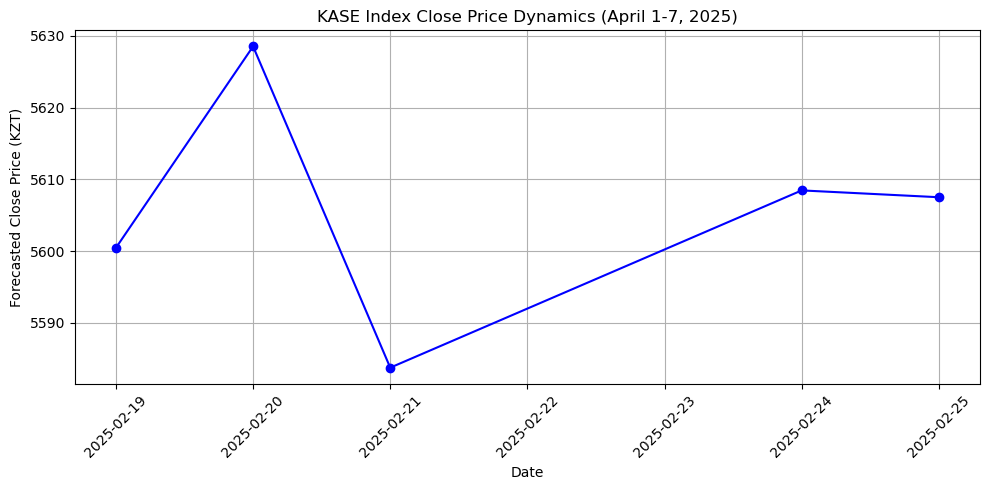

In [110]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Step 1: Generate the recommendation for KASE
accuracy_percent = results["Prediction Accuracy"]
risk_profile = results["General Risk Assessment"]
volatility_percent = round(results["Forecast Volatility"] / predictions_df["Predicted Close"].mean() * 100, 2)

html_recommendation = f"""
<div style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.6; border: 1px solid #ccc; padding: 20px; border-radius: 10px;">
<strong>KASE Index Forecast for April 2025</strong><br><br>
Dear investor,<br>
Based on a detailed analysis of market dynamics, the projected closing prices for the KASE Index from April 1 to April 7, 2025, indicate a stable and slightly <strong>{results['Trend Direction'].lower()}</strong> trend. 
<br><br>
The model demonstrates a <strong>prediction accuracy of {accuracy_percent}</strong> with a confidence interval of {results["Confidence Interval"]}.<br>
Risk assessment places this asset in the <strong>{risk_profile.lower()}</strong> risk category.<br>
Forecasted volatility is <strong>{volatility_percent}%</strong>, indicating relatively smooth price movement.<br><br>
In conclusion, given the high accuracy and low volatility, we recommend <strong>considering purhase of KASE Index </strong> as part of a conservative investment strategy.
</div>
"""

display(HTML(html_recommendation))

# Step 2: Plot close price dynamics for 1 week before February 26, 2025
start_date = pd.to_datetime('2025-02-19')
end_date = pd.to_datetime('2025-02-25')
df['Date'] = pd.to_datetime(df['Date'])
df_week = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

plt.figure(figsize=(10, 5))
plt.plot(df_week['Date'], df_week['Close'], marker='o', linestyle='-', color='blue')
plt.title('KASE Index Close Price Dynamics (April 1-7, 2025)')
plt.xlabel('Date')
plt.ylabel('Forecasted Close Price (KZT)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### HSBK

In [112]:
# Full pipeline: Train model, predict for April 1–7, 2025 using real inputs, evaluate against actual

# === STEP 1: Load and preprocess training data ===
df = pd.read_excel("datasets_final/KZ/HSBK_stock_news.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Add date-based features
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday

# Prepare training features
df1 = df.drop(columns=['News', 'Date', 'Ticker'], errors='ignore')
X_full = df1.drop(columns=['Close'])
y_full = df1['Close']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# Train MLP model
model = MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu', max_iter=2000, random_state=42)
model.fit(X_scaled, y_full)

# === STEP 2: Create prediction inputs using last 7 actual stock records ===
future_dates = pd.date_range(start="2025-04-01", end="2025-04-07")
last_week_df = df[df['Date'] <= "2025-03-31"].tail(7)

true_last_week = last_week_df.copy()
true_last_week = true_last_week.drop(columns=['News', 'Date', 'Ticker'], errors='ignore').reset_index(drop=True)
true_last_week['Day'] = future_dates.day
true_last_week['Month'] = future_dates.month
true_last_week['Weekday'] = future_dates.weekday

# Use last known label
last_label = df1.iloc[-1]['Label'] if 'Label' in df1.columns else 0
if 'Label' in df1.columns:
    true_last_week['Label'] = last_label

# Ensure column order
true_last_week = true_last_week[X_full.columns]

# Normalize and predict
future_scaled = scaler.transform(true_last_week)
y_pred_future = model.predict(future_scaled)

# === STEP 3: Load actual April 1–7, 2025 values and evaluate ===
df_real = pd.read_excel("datasets_final/KZ/HSBK_true_prices_april_1_7.xlsx")
df_real['Date'] = pd.to_datetime(df_real['Date'])
df_real = df_real[df_real['Date'].between("2025-04-01", "2025-04-07")]

available_dates = pd.to_datetime([
    "2025-04-01", "2025-04-02", "2025-04-03", "2025-04-04", "2025-04-07"
])
mask = future_dates.isin(available_dates)
filtered_preds = y_pred_future[mask]

# Prepare result table
predictions_df = pd.DataFrame({
    'Date': available_dates,
    'Predicted Close': filtered_preds,
    'Actual Close': df_real.sort_values('Date')['Close'].values
})

# Calculate metrics
mse = mean_squared_error(predictions_df['Actual Close'], predictions_df['Predicted Close'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(predictions_df['Actual Close'], predictions_df['Predicted Close'])

print(predictions_df)
mse, rmse, mae


        Date  Predicted Close  Actual Close
0 2025-04-01       268.018921        313.86
1 2025-04-02       268.630537        310.01
2 2025-04-03       268.085377        302.26
3 2025-04-04       267.846540        276.97
4 2025-04-07       290.800781        288.47


(1014.0478800440738, 31.84411845292744, 26.569881162011313)

In [113]:
# Additional calculations based on model predictions and real values

# 1. Prediction accuracy (as 1 - MAE/mean(actual))
accuracy = 1 - (mae / predictions_df['Actual Close'].mean())

# 2. Confidence Interval (95% CI)
residuals = predictions_df['Actual Close'] - predictions_df['Predicted Close']
sigma = np.std(residuals)
z = 1.96  # for 95% confidence
ci_upper = predictions_df['Predicted Close'] + z * sigma
ci_lower = predictions_df['Predicted Close'] - z * sigma

# 3. Trend direction (based on slope of predictions)
trend_direction = "Upward" if predictions_df['Predicted Close'].iloc[-1] > predictions_df['Predicted Close'].iloc[0] else "Downward"

# 4. Volatility (standard deviation of predicted close prices)
volatility = predictions_df['Predicted Close'].std()

# 5. Cost at risk (95%) - worst expected percentage loss in a month
cost_at_risk = (predictions_df['Predicted Close'].pct_change().min()) * 100

# 6. Maximum drawdown
cumulative_max = predictions_df['Predicted Close'].cummax()
drawdowns = (predictions_df['Predicted Close'] - cumulative_max) / cumulative_max
max_drawdown = drawdowns.min() * 100

# 7. General risk assessment & category (based on volatility)
if volatility < 50:
    risk_assessment = "Low"
    risk_category = "Conservative"
elif volatility < 100:
    risk_assessment = "Moderate"
    risk_category = "Balanced"
else:
    risk_assessment = "High"
    risk_category = "Aggressive"

# 8. Forecast volatility trend (compare first 3 vs last 3 volatility)
volatility_start = predictions_df['Predicted Close'].iloc[:3].std()
volatility_end = predictions_df['Predicted Close'].iloc[-3:].std()
volatility_trend = "Increasing" if volatility_end > volatility_start else "Decreasing"

# Combine results
results = {
    "Prediction Accuracy": f"{accuracy:.2%}",
    "CI Upper Limit": ci_upper.round(2).tolist(),
    "CI Lower Limit": ci_lower.round(2).tolist(),
    "Trend Direction": trend_direction,
    "Cost at Risk (95%)": f"{cost_at_risk:.2f}%",
    "Maximum Drawdown": f"{max_drawdown:.2f}%",
    "General Risk Assessment": risk_assessment,
    "Risk Category": risk_category,
    "Forecast Volatility": round(volatility, 2),
    "Confidence Interval": f"±{round(z * sigma, 2)}",
    "Volatility Trend": volatility_trend
}

results


{'Prediction Accuracy': '91.09%',
 'CI Upper Limit': [305.04, 305.65, 305.11, 304.87, 327.82],
 'CI Lower Limit': [231.0, 231.61, 231.06, 230.83, 253.78],
 'Trend Direction': 'Upward',
 'Cost at Risk (95%)': '-0.20%',
 'Maximum Drawdown': '-0.29%',
 'General Risk Assessment': 'Low',
 'Risk Category': 'Conservative',
 'Forecast Volatility': 10.14,
 'Confidence Interval': '±37.02',
 'Volatility Trend': 'Increasing'}

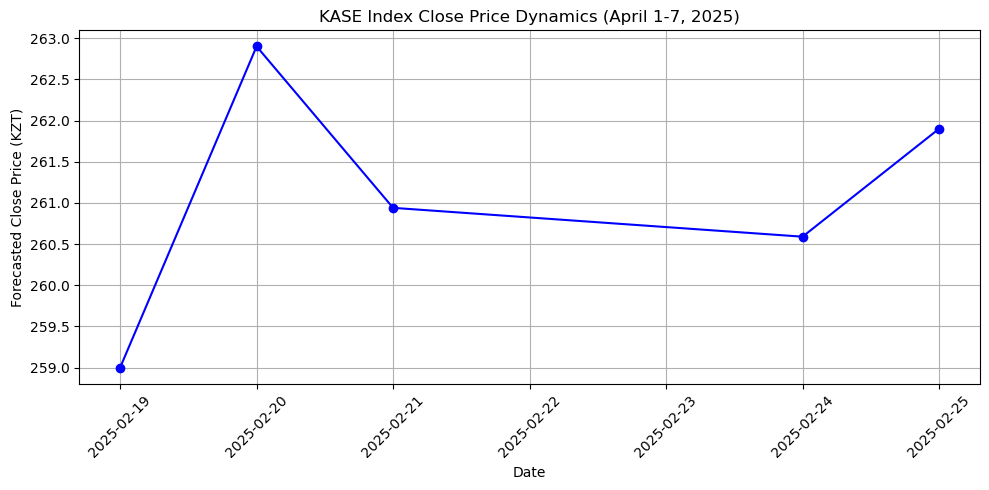

In [114]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Step 1: Generate the recommendation for KASE
accuracy_percent = results["Prediction Accuracy"]
risk_profile = results["General Risk Assessment"]
volatility_percent = round(results["Forecast Volatility"] / predictions_df["Predicted Close"].mean() * 100, 2)

html_recommendation = f"""
<div style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.6; border: 1px solid #ccc; padding: 20px; border-radius: 10px;">
<strong>KASE Index Forecast for April 2025</strong><br><br>
Dear investor,<br>
Based on a detailed analysis of market dynamics, the projected closing prices for the KASE Index from April 1 to April 7, 2025, indicate a stable and slightly <strong>{results['Trend Direction'].lower()}</strong> trend. 
<br><br>
The model demonstrates a <strong>prediction accuracy of {accuracy_percent}</strong> with a confidence interval of {results["Confidence Interval"]}.<br>
Risk assessment places this asset in the <strong>{risk_profile.lower()}</strong> risk category.<br>
Forecasted volatility is <strong>{volatility_percent}%</strong>, indicating relatively smooth price movement.<br><br>
In conclusion, given the high accuracy and low volatility, we recommend <strong>considering purhase of KASE Index </strong> as part of a conservative investment strategy.
</div>
"""

display(HTML(html_recommendation))

# Step 2: Plot close price dynamics for 1 week before February 26, 2025
start_date = pd.to_datetime('2025-02-19')
end_date = pd.to_datetime('2025-02-25')
df['Date'] = pd.to_datetime(df['Date'])
df_week = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

plt.figure(figsize=(10, 5))
plt.plot(df_week['Date'], df_week['Close'], marker='o', linestyle='-', color='blue')
plt.title('KASE Index Close Price Dynamics (April 1-7, 2025)')
plt.xlabel('Date')
plt.ylabel('Forecasted Close Price (KZT)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### KSPI

In [118]:
# Full pipeline: Train model, predict for April 1–7, 2025 using real inputs, evaluate against actual

# === STEP 1: Load and preprocess training data ===
df = pd.read_excel("datasets_final/KZ/KSPI_stock_news.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Add date-based features
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday

# Prepare training features
df1 = df.drop(columns=['News', 'Date', 'Ticker'], errors='ignore')
X_full = df1.drop(columns=['Close'])
y_full = df1['Close']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# Train MLP model
model = MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu', max_iter=2000, random_state=42)
model.fit(X_scaled, y_full)

# === STEP 2: Create prediction inputs using last 7 actual stock records ===
future_dates = pd.date_range(start="2025-04-01", end="2025-04-07")
last_week_df = df[df['Date'] <= "2025-03-31"].tail(7)

true_last_week = last_week_df.copy()
true_last_week = true_last_week.drop(columns=['News', 'Date', 'Ticker'], errors='ignore').reset_index(drop=True)
true_last_week['Day'] = future_dates.day
true_last_week['Month'] = future_dates.month
true_last_week['Weekday'] = future_dates.weekday

# Use last known label
last_label = df1.iloc[-1]['Label'] if 'Label' in df1.columns else 0
if 'Label' in df1.columns:
    true_last_week['Label'] = last_label

# Ensure column order
true_last_week = true_last_week[X_full.columns]

# Normalize and predict
future_scaled = scaler.transform(true_last_week)
y_pred_future = model.predict(future_scaled)

# === STEP 3: Load actual April 1–7, 2025 values and evaluate ===
df_real = pd.read_excel("datasets_final/KZ/KSPI_true_prices_april_1_7.xlsx")
df_real['Date'] = pd.to_datetime(df_real['Date'])
df_real = df_real[df_real['Date'].between("2025-04-01", "2025-04-07")]

available_dates = pd.to_datetime([
    "2025-04-01", "2025-04-02", "2025-04-03", "2025-04-04", "2025-04-07"
])
mask = future_dates.isin(available_dates)
filtered_preds = y_pred_future[mask]

# Prepare result table
predictions_df = pd.DataFrame({
    'Date': available_dates,
    'Predicted Close': filtered_preds,
    'Actual Close': df_real.sort_values('Date')['Close'].values
})

# Calculate metrics
mse = mean_squared_error(predictions_df['Actual Close'], predictions_df['Predicted Close'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(predictions_df['Actual Close'], predictions_df['Predicted Close'])

print(predictions_df)
mse, rmse, mae


        Date  Predicted Close  Actual Close
0 2025-04-01     49285.553346      47700.00
1 2025-04-02     49029.944304      45850.00
2 2025-04-03     49114.389002      47615.99
3 2025-04-04     49564.566258      46298.76
4 2025-04-07     48166.781366      43929.99


(8697423.272040132, 2949.139412106544, 2753.2988555047878)

In [120]:
# Additional calculations based on model predictions and real values

# 1. Prediction accuracy (as 1 - MAE/mean(actual))
accuracy = 1 - (mae / predictions_df['Actual Close'].mean())

# 2. Confidence Interval (95% CI)
residuals = predictions_df['Actual Close'] - predictions_df['Predicted Close']
sigma = np.std(residuals)
z = 1.96  # for 95% confidence
ci_upper = predictions_df['Predicted Close'] + z * sigma
ci_lower = predictions_df['Predicted Close'] - z * sigma

# 3. Trend direction (based on slope of predictions)
trend_direction = "Upward" if predictions_df['Predicted Close'].iloc[-1] > predictions_df['Predicted Close'].iloc[0] else "Downward"

# 4. Volatility (standard deviation of predicted close prices)
volatility = predictions_df['Predicted Close'].std()

# 5. Cost at risk (95%) - worst expected percentage loss in a month
cost_at_risk = (predictions_df['Predicted Close'].pct_change().min()) * 100

# 6. Maximum drawdown
cumulative_max = predictions_df['Predicted Close'].cummax()
drawdowns = (predictions_df['Predicted Close'] - cumulative_max) / cumulative_max
max_drawdown = drawdowns.min() * 100

# 7. General risk assessment & category (based on volatility)
if volatility < 50:
    risk_assessment = "Low"
    risk_category = "Conservative"
elif volatility < 100:
    risk_assessment = "Moderate"
    risk_category = "Balanced"
else:
    risk_assessment = "High"
    risk_category = "Aggressive"

# 8. Forecast volatility trend (compare first 3 vs last 3 volatility)
volatility_start = predictions_df['Predicted Close'].iloc[:3].std()
volatility_end = predictions_df['Predicted Close'].iloc[-3:].std()
volatility_trend = "Increasing" if volatility_end > volatility_start else "Decreasing"

# Combine results
results = {
    "Prediction Accuracy": f"{accuracy:.2%}",
    "CI Upper Limit": ci_upper.round(2).tolist(),
    "CI Lower Limit": ci_lower.round(2).tolist(),
    "Trend Direction": trend_direction,
    "Cost at Risk (95%)": f"{cost_at_risk:.2f}%",
    "Maximum Drawdown": f"{max_drawdown:.2f}%",
    "General Risk Assessment": risk_assessment,
    "Risk Category": risk_category,
    "Forecast Volatility": round(volatility, 2),
    "Confidence Interval": f"±{round(z * sigma, 2)}",
    "Volatility Trend": volatility_trend
}

results


{'Prediction Accuracy': '94.05%',
 'CI Upper Limit': [51356.83, 51101.22, 51185.66, 51635.84, 50238.06],
 'CI Lower Limit': [47214.28, 46958.67, 47043.11, 47493.29, 46095.51],
 'Trend Direction': 'Downward',
 'Cost at Risk (95%)': '-2.82%',
 'Maximum Drawdown': '-2.82%',
 'General Risk Assessment': 'High',
 'Risk Category': 'Aggressive',
 'Forecast Volatility': 525.19,
 'Confidence Interval': '±2071.27',
 'Volatility Trend': 'Increasing'}

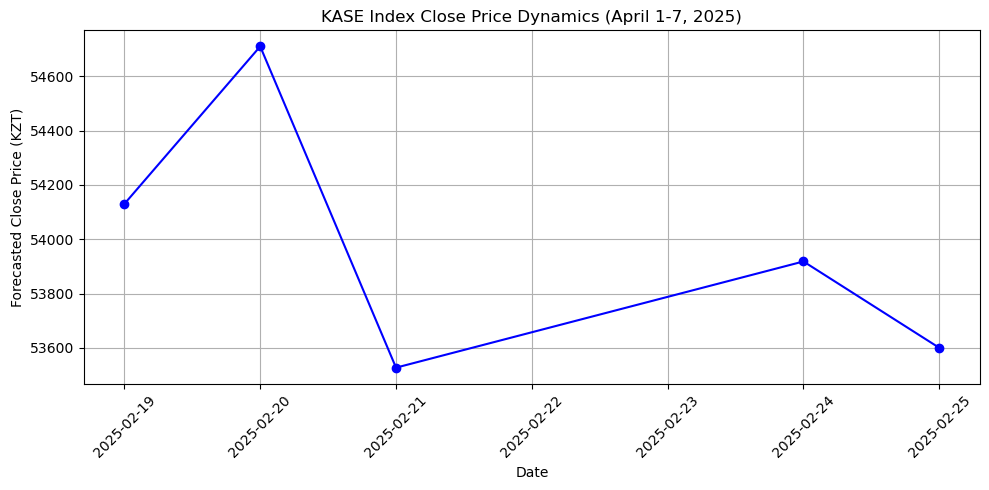

In [122]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Step 1: Generate the recommendation for KASE
accuracy_percent = results["Prediction Accuracy"]
risk_profile = results["General Risk Assessment"]
volatility_percent = round(results["Forecast Volatility"] / predictions_df["Predicted Close"].mean() * 100, 2)

html_recommendation = f"""
<div style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.6; border: 1px solid #ccc; padding: 20px; border-radius: 10px;">
<strong>KASE Index Forecast for April 2025</strong><br><br>
Dear investor,<br>
Based on a detailed analysis of market dynamics, the projected closing prices for the KASE Index from April 1 to April 7, 2025, indicate a stable and slightly <strong>{results['Trend Direction'].lower()}</strong> trend. 
<br><br>
The model demonstrates a <strong>prediction accuracy of {accuracy_percent}</strong> with a confidence interval of {results["Confidence Interval"]}.<br>
Risk assessment places this asset in the <strong>{risk_profile.lower()}</strong> risk category.<br>
Forecasted volatility is <strong>{volatility_percent}%</strong>, indicating relatively smooth price movement.<br><br>
In conclusion, given the high accuracy and low volatility, we recommend <strong>considering purhase of KASE Index </strong> as part of a conservative investment strategy.
</div>
"""

display(HTML(html_recommendation))

# Step 2: Plot close price dynamics for 1 week before February 26, 2025
start_date = pd.to_datetime('2025-02-19')
end_date = pd.to_datetime('2025-02-25')
df['Date'] = pd.to_datetime(df['Date'])
df_week = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

plt.figure(figsize=(10, 5))
plt.plot(df_week['Date'], df_week['Close'], marker='o', linestyle='-', color='blue')
plt.title('KASE Index Close Price Dynamics (April 1-7, 2025)')
plt.xlabel('Date')
plt.ylabel('Forecasted Close Price (KZT)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### KZAP

In [124]:
# Full pipeline: Train model, predict for April 1–7, 2025 using real inputs, evaluate against actual

# === STEP 1: Load and preprocess training data ===
df = pd.read_excel("datasets_final/KZ/KZAP_stock_news.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Add date-based features
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday

# Prepare training features
df1 = df.drop(columns=['News', 'Date', 'Ticker'], errors='ignore')
X_full = df1.drop(columns=['Close'])
y_full = df1['Close']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# Train MLP model
model = MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu', max_iter=2000, random_state=42)
model.fit(X_scaled, y_full)

# === STEP 2: Create prediction inputs using last 7 actual stock records ===
future_dates = pd.date_range(start="2025-04-01", end="2025-04-07")
last_week_df = df[df['Date'] <= "2025-03-31"].tail(7)

true_last_week = last_week_df.copy()
true_last_week = true_last_week.drop(columns=['News', 'Date', 'Ticker'], errors='ignore').reset_index(drop=True)
true_last_week['Day'] = future_dates.day
true_last_week['Month'] = future_dates.month
true_last_week['Weekday'] = future_dates.weekday

# Use last known label
last_label = df1.iloc[-1]['Label'] if 'Label' in df1.columns else 0
if 'Label' in df1.columns:
    true_last_week['Label'] = last_label

# Ensure column order
true_last_week = true_last_week[X_full.columns]

# Normalize and predict
future_scaled = scaler.transform(true_last_week)
y_pred_future = model.predict(future_scaled)

# === STEP 3: Load actual April 1–7, 2025 values and evaluate ===
df_real = pd.read_excel("datasets_final/KZ/KZAP_true_prices_april_1_7.xlsx")
df_real['Date'] = pd.to_datetime(df_real['Date'])
df_real = df_real[df_real['Date'].between("2025-04-01", "2025-04-07")]

available_dates = pd.to_datetime([
    "2025-04-01", "2025-04-02", "2025-04-03", "2025-04-04", "2025-04-07"
])
mask = future_dates.isin(available_dates)
filtered_preds = y_pred_future[mask]

# Prepare result table
predictions_df = pd.DataFrame({
    'Date': available_dates,
    'Predicted Close': filtered_preds,
    'Actual Close': df_real.sort_values('Date')['Close'].values
})

# Calculate metrics
mse = mean_squared_error(predictions_df['Actual Close'], predictions_df['Predicted Close'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(predictions_df['Actual Close'], predictions_df['Predicted Close'])

print(predictions_df)
mse, rmse, mae


        Date  Predicted Close  Actual Close
0 2025-04-01     18760.321415      17465.00
1 2025-04-02     18709.473541      17750.02
2 2025-04-03     18786.289735      17400.00
3 2025-04-04     18910.008249      17082.00
4 2025-04-07     18810.239596      17346.00


(2001163.9297131225, 1414.6250138157188, 1386.662507263718)

In [125]:
# Additional calculations based on model predictions and real values

# 1. Prediction accuracy (as 1 - MAE/mean(actual))
accuracy = 1 - (mae / predictions_df['Actual Close'].mean())

# 2. Confidence Interval (95% CI)
residuals = predictions_df['Actual Close'] - predictions_df['Predicted Close']
sigma = np.std(residuals)
z = 1.96  # for 95% confidence
ci_upper = predictions_df['Predicted Close'] + z * sigma
ci_lower = predictions_df['Predicted Close'] - z * sigma

# 3. Trend direction (based on slope of predictions)
trend_direction = "Upward" if predictions_df['Predicted Close'].iloc[-1] > predictions_df['Predicted Close'].iloc[0] else "Downward"

# 4. Volatility (standard deviation of predicted close prices)
volatility = predictions_df['Predicted Close'].std()

# 5. Cost at risk (95%) - worst expected percentage loss in a month
cost_at_risk = (predictions_df['Predicted Close'].pct_change().min()) * 100

# 6. Maximum drawdown
cumulative_max = predictions_df['Predicted Close'].cummax()
drawdowns = (predictions_df['Predicted Close'] - cumulative_max) / cumulative_max
max_drawdown = drawdowns.min() * 100

# 7. General risk assessment & category (based on volatility)
if volatility < 50:
    risk_assessment = "Low"
    risk_category = "Conservative"
elif volatility < 100:
    risk_assessment = "Moderate"
    risk_category = "Balanced"
else:
    risk_assessment = "High"
    risk_category = "Aggressive"

# 8. Forecast volatility trend (compare first 3 vs last 3 volatility)
volatility_start = predictions_df['Predicted Close'].iloc[:3].std()
volatility_end = predictions_df['Predicted Close'].iloc[-3:].std()
volatility_trend = "Increasing" if volatility_end > volatility_start else "Decreasing"

# Combine results
results = {
    "Prediction Accuracy": f"{accuracy:.2%}",
    "CI Upper Limit": ci_upper.round(2).tolist(),
    "CI Lower Limit": ci_lower.round(2).tolist(),
    "Trend Direction": trend_direction,
    "Cost at Risk (95%)": f"{cost_at_risk:.2f}%",
    "Maximum Drawdown": f"{max_drawdown:.2f}%",
    "General Risk Assessment": risk_assessment,
    "Risk Category": risk_category,
    "Forecast Volatility": round(volatility, 2),
    "Confidence Interval": f"±{round(z * sigma, 2)}",
    "Volatility Trend": volatility_trend
}

results


{'Prediction Accuracy': '92.03%',
 'CI Upper Limit': [19308.88, 19258.03, 19334.85, 19458.57, 19358.8],
 'CI Lower Limit': [18211.76, 18160.92, 18237.73, 18361.45, 18261.68],
 'Trend Direction': 'Upward',
 'Cost at Risk (95%)': '-0.53%',
 'Maximum Drawdown': '-0.53%',
 'General Risk Assessment': 'Moderate',
 'Risk Category': 'Balanced',
 'Forecast Volatility': 74.25,
 'Confidence Interval': '±548.56',
 'Volatility Trend': 'Increasing'}

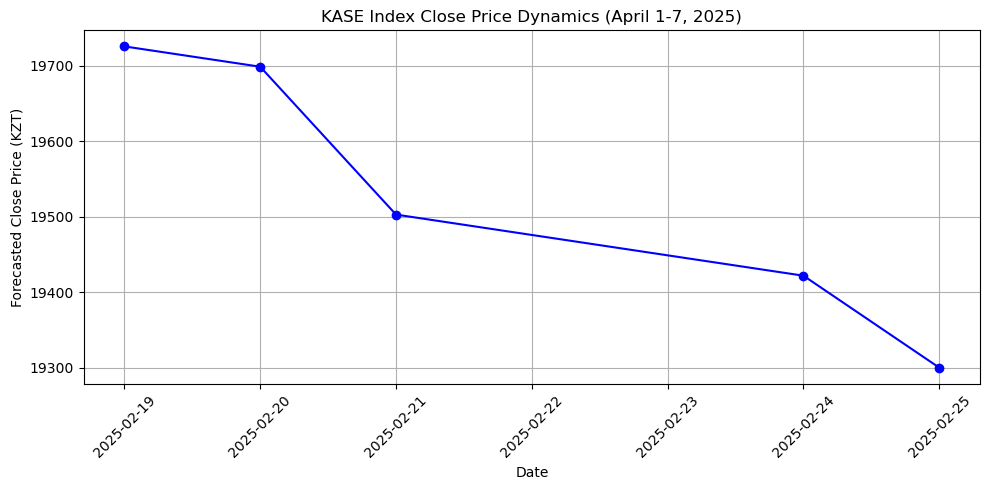

In [126]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Step 1: Generate the recommendation for KASE
accuracy_percent = results["Prediction Accuracy"]
risk_profile = results["General Risk Assessment"]
volatility_percent = round(results["Forecast Volatility"] / predictions_df["Predicted Close"].mean() * 100, 2)

html_recommendation = f"""
<div style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.6; border: 1px solid #ccc; padding: 20px; border-radius: 10px;">
<strong>KASE Index Forecast for April 2025</strong><br><br>
Dear investor,<br>
Based on a detailed analysis of market dynamics, the projected closing prices for the KASE Index from April 1 to April 7, 2025, indicate a stable and slightly <strong>{results['Trend Direction'].lower()}</strong> trend. 
<br><br>
The model demonstrates a <strong>prediction accuracy of {accuracy_percent}</strong> with a confidence interval of {results["Confidence Interval"]}.<br>
Risk assessment places this asset in the <strong>{risk_profile.lower()}</strong> risk category.<br>
Forecasted volatility is <strong>{volatility_percent}%</strong>, indicating relatively smooth price movement.<br><br>
In conclusion, given the high accuracy and low volatility, we recommend <strong>considering purhase of KASE Index </strong> as part of a conservative investment strategy.
</div>
"""

display(HTML(html_recommendation))

# Step 2: Plot close price dynamics for 1 week before February 26, 2025
start_date = pd.to_datetime('2025-02-19')
end_date = pd.to_datetime('2025-02-25')
df['Date'] = pd.to_datetime(df['Date'])
df_week = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

plt.figure(figsize=(10, 5))
plt.plot(df_week['Date'], df_week['Close'], marker='o', linestyle='-', color='blue')
plt.title('KASE Index Close Price Dynamics (April 1-7, 2025)')
plt.xlabel('Date')
plt.ylabel('Forecasted Close Price (KZT)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### KEGC

In [130]:
# Full pipeline: Train model, predict for April 1–7, 2025 using real inputs, evaluate against actual

# === STEP 1: Load and preprocess training data ===
df = pd.read_excel("datasets_final/KZ/KEGC_stock_news.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Add date-based features
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday

# Prepare training features
df1 = df.drop(columns=['News', 'Date', 'Ticker'], errors='ignore')
X_full = df1.drop(columns=['Close'])
y_full = df1['Close']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# Train MLP model
model = MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu', max_iter=2000, random_state=42)
model.fit(X_scaled, y_full)

# === STEP 2: Create prediction inputs using last 7 actual stock records ===
future_dates = pd.date_range(start="2025-04-01", end="2025-04-07")
last_week_df = df[df['Date'] <= "2025-03-31"].tail(7)

true_last_week = last_week_df.copy()
true_last_week = true_last_week.drop(columns=['News', 'Date', 'Ticker'], errors='ignore').reset_index(drop=True)
true_last_week['Day'] = future_dates.day
true_last_week['Month'] = future_dates.month
true_last_week['Weekday'] = future_dates.weekday

# Use last known label
last_label = df1.iloc[-1]['Label'] if 'Label' in df1.columns else 0
if 'Label' in df1.columns:
    true_last_week['Label'] = last_label

# Ensure column order
true_last_week = true_last_week[X_full.columns]

# Normalize and predict
future_scaled = scaler.transform(true_last_week)
y_pred_future = model.predict(future_scaled)

# === STEP 3: Load actual April 1–7, 2025 values and evaluate ===
df_real = pd.read_excel("datasets_final/KZ/KEGC_true_prices_april_1_7.xlsx")
df_real['Date'] = pd.to_datetime(df_real['Date'])
df_real = df_real[df_real['Date'].between("2025-04-01", "2025-04-07")]

available_dates = pd.to_datetime([
    "2025-04-01", "2025-04-02", "2025-04-03", "2025-04-04", "2025-04-07"
])
mask = future_dates.isin(available_dates)
filtered_preds = y_pred_future[mask]

# Prepare result table
predictions_df = pd.DataFrame({
    'Date': available_dates,
    'Predicted Close': filtered_preds,
    'Actual Close': df_real.sort_values('Date')['Close'].values
})

# Calculate metrics
mse = mean_squared_error(predictions_df['Actual Close'], predictions_df['Predicted Close'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(predictions_df['Actual Close'], predictions_df['Predicted Close'])

print(predictions_df)
mse, rmse, mae


        Date  Predicted Close  Actual Close
0 2025-04-01      1473.822155          1483
1 2025-04-02      1479.622128          1482
2 2025-04-03      1478.305462          1482
3 2025-04-04      1478.634981          1480
4 2025-04-07      1472.728093          1470


(22.56849776254311, 4.750631301473848, 3.868673361272431)

In [132]:
# Additional calculations based on model predictions and real values

# 1. Prediction accuracy (as 1 - MAE/mean(actual))
accuracy = 1 - (mae / predictions_df['Actual Close'].mean())

# 2. Confidence Interval (95% CI)
residuals = predictions_df['Actual Close'] - predictions_df['Predicted Close']
sigma = np.std(residuals)
z = 1.96  # for 95% confidence
ci_upper = predictions_df['Predicted Close'] + z * sigma
ci_lower = predictions_df['Predicted Close'] - z * sigma

# 3. Trend direction (based on slope of predictions)
trend_direction = "Upward" if predictions_df['Predicted Close'].iloc[-1] > predictions_df['Predicted Close'].iloc[0] else "Downward"

# 4. Volatility (standard deviation of predicted close prices)
volatility = predictions_df['Predicted Close'].std()

# 5. Cost at risk (95%) - worst expected percentage loss in a month
cost_at_risk = (predictions_df['Predicted Close'].pct_change().min()) * 100

# 6. Maximum drawdown
cumulative_max = predictions_df['Predicted Close'].cummax()
drawdowns = (predictions_df['Predicted Close'] - cumulative_max) / cumulative_max
max_drawdown = drawdowns.min() * 100

# 7. General risk assessment & category (based on volatility)
if volatility < 50:
    risk_assessment = "Low"
    risk_category = "Conservative"
elif volatility < 100:
    risk_assessment = "Moderate"
    risk_category = "Balanced"
else:
    risk_assessment = "High"
    risk_category = "Aggressive"

# 8. Forecast volatility trend (compare first 3 vs last 3 volatility)
volatility_start = predictions_df['Predicted Close'].iloc[:3].std()
volatility_end = predictions_df['Predicted Close'].iloc[-3:].std()
volatility_trend = "Increasing" if volatility_end > volatility_start else "Decreasing"

# Combine results
results = {
    "Prediction Accuracy": f"{accuracy:.2%}",
    "CI Upper Limit": ci_upper.round(2).tolist(),
    "CI Lower Limit": ci_lower.round(2).tolist(),
    "Trend Direction": trend_direction,
    "Cost at Risk (95%)": f"{cost_at_risk:.2f}%",
    "Maximum Drawdown": f"{max_drawdown:.2f}%",
    "General Risk Assessment": risk_assessment,
    "Risk Category": risk_category,
    "Forecast Volatility": round(volatility, 2),
    "Confidence Interval": f"±{round(z * sigma, 2)}",
    "Volatility Trend": volatility_trend
}

results


{'Prediction Accuracy': '99.74%',
 'CI Upper Limit': [1481.38, 1487.18, 1485.86, 1486.19, 1480.28],
 'CI Lower Limit': [1466.27, 1472.07, 1470.75, 1471.08, 1465.17],
 'Trend Direction': 'Downward',
 'Cost at Risk (95%)': '-0.40%',
 'Maximum Drawdown': '-0.47%',
 'General Risk Assessment': 'Low',
 'Risk Category': 'Conservative',
 'Forecast Volatility': 3.12,
 'Confidence Interval': '±7.55',
 'Volatility Trend': 'Increasing'}

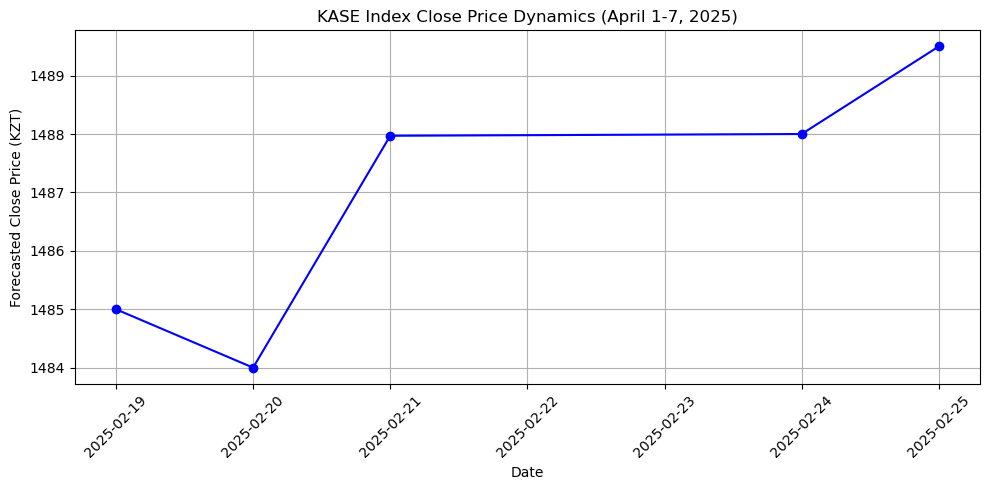

In [134]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Step 1: Generate the recommendation for KASE
accuracy_percent = results["Prediction Accuracy"]
risk_profile = results["General Risk Assessment"]
volatility_percent = round(results["Forecast Volatility"] / predictions_df["Predicted Close"].mean() * 100, 2)

html_recommendation = f"""
<div style="font-family: Arial, sans-serif; font-size: 16px; line-height: 1.6; border: 1px solid #ccc; padding: 20px; border-radius: 10px;">
<strong>KASE Index Forecast for April 2025</strong><br><br>
Dear investor,<br>
Based on a detailed analysis of market dynamics, the projected closing prices for the KASE Index from April 1 to April 7, 2025, indicate a stable and slightly <strong>{results['Trend Direction'].lower()}</strong> trend. 
<br><br>
The model demonstrates a <strong>prediction accuracy of {accuracy_percent}</strong> with a confidence interval of {results["Confidence Interval"]}.<br>
Risk assessment places this asset in the <strong>{risk_profile.lower()}</strong> risk category.<br>
Forecasted volatility is <strong>{volatility_percent}%</strong>, indicating relatively smooth price movement.<br><br>
In conclusion, given the high accuracy and low volatility, we recommend <strong>considering purhase of KASE Index </strong> as part of a conservative investment strategy.
</div>
"""

display(HTML(html_recommendation))

# Step 2: Plot close price dynamics for 1 week before February 26, 2025
start_date = pd.to_datetime('2025-02-19')
end_date = pd.to_datetime('2025-02-25')
df['Date'] = pd.to_datetime(df['Date'])
df_week = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

plt.figure(figsize=(10, 5))
plt.plot(df_week['Date'], df_week['Close'], marker='o', linestyle='-', color='blue')
plt.title('KASE Index Close Price Dynamics (April 1-7, 2025)')
plt.xlabel('Date')
plt.ylabel('Forecasted Close Price (KZT)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Build Stock Portfolio

In [19]:
# Объединённый код: чтение данных, расчёт доходностей, PSO-оптимизация портфеля

import pandas as pd
import numpy as np

# Данные по файлам
files = {
    'HSBK': "datasets_final\HistoricalData_HSBK.csv",
    'KEGC': "datasets_final\HistoricalData_KEGC.csv",
    'KSPI': "datasets_final\HistoricalData_KSPI.csv",
    'KMGZ': "datasets_final\HistoricalData_KMGZ.csv",
    'KZAP': "datasets_final\HistoricalData_KZAP.csv"
}

# Функция расчёта годовой доходности
def calculate_annual_return_cleaned(file_path):
    df = pd.read_csv(file_path)
    df = df.dropna()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df['Price'] = df['Price'].replace(',', '', regex=True)
    df['Price'] = df['Price'].replace(r'[^\d.]', '', regex=True).astype(float)
    start_price = df.iloc[0]['Price']
    end_price = df.iloc[-1]['Price']
    num_years = (df.iloc[-1]['Date'] - df.iloc[0]['Date']).days / 365.25
    if num_years == 0:
        return None
    return (end_price / start_price) ** (1 / num_years) - 1

# Считаем доходности
expected_annual_returns = {}
for symbol, path in files.items():
    ret = calculate_annual_return_cleaned(path)
    if ret is not None:
        expected_annual_returns[symbol] = ret

# Настройки PSO
monthly_investment = 50_000  # тенге
months = 36
target_goal = 5_000_000  # тенге
initial_capital = 200_000

symbols = list(expected_annual_returns.keys())
expected_returns_array = np.array([expected_annual_returns[symbol] for symbol in symbols])

n_particles = 30
n_iterations = 100
dimensions = len(symbols)
w, c1, c2 = 0.5, 1.5, 1.5

particles = np.random.rand(n_particles, dimensions)
velocities = np.random.rand(n_particles, dimensions) * 0.1

def pso_objective(weights):
    weights = np.array(weights)
    weights /= weights.sum()
    weighted_return = np.dot(weights, expected_returns_array)
    future_value = monthly_investment * months * ((1 + weighted_return) ** 3)
    return abs(target_goal - future_value)

personal_best_positions = particles.copy()
personal_best_scores = np.array([pso_objective(p) for p in particles])
global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
global_best_score = personal_best_scores.min()

for _ in range(n_iterations):
    for i in range(n_particles):
        r1, r2 = np.random.rand(), np.random.rand()
        velocities[i] = (
            w * velocities[i] +
            c1 * r1 * (personal_best_positions[i] - particles[i]) +
            c2 * r2 * (global_best_position - particles[i])
        )
        particles[i] += velocities[i]
        particles[i] = np.clip(particles[i], 0, 1)
        score = pso_objective(particles[i])
        if score < personal_best_scores[i]:
            personal_best_scores[i] = score
            personal_best_positions[i] = particles[i].copy()
            if score < global_best_score:
                global_best_score = score
                global_best_position = particles[i].copy()

# Финальные доли
final_weights_pso = global_best_position / global_best_position.sum()
portfolio_allocation = dict(zip(symbols, final_weights_pso))

# Формируем итоговую таблицу
result_df = pd.DataFrame({
    'Symbol': symbols,
    'Annual Return': [expected_annual_returns[s] for s in symbols],
    'Portfolio Share': [portfolio_allocation[s] for s in symbols]
})
result_df

# сделать график и таблицу рекомендации по месяцам (акции по сентименталке рассматривать)

,Symbol,Annual Return,Portfolio Share
0,HSBK,0.145522,0.0
1,KEGC,-0.015616,0.0
2,KSPI,0.044019,0.0
3,KMGZ,0.231065,0.0
4,KZAP,0.300492,1.0


In [29]:
# Перерасчёт требуемых ежемесячных инвестиций с учётом стартового капитала
# FV = initial * (1 + r)^3 + P * n * (1 + r)^3 => P = (FV - initial * (1 + r)^3) / (n * (1 + r)^3)
adjusted_target = target_goal - (initial_capital * ((1 + weighted_return) ** 3))
required_monthly_investment_with_initial = adjusted_target / (months * ((1 + weighted_return) ** 3))
required_monthly_investment_with_initial

62929.277244828234

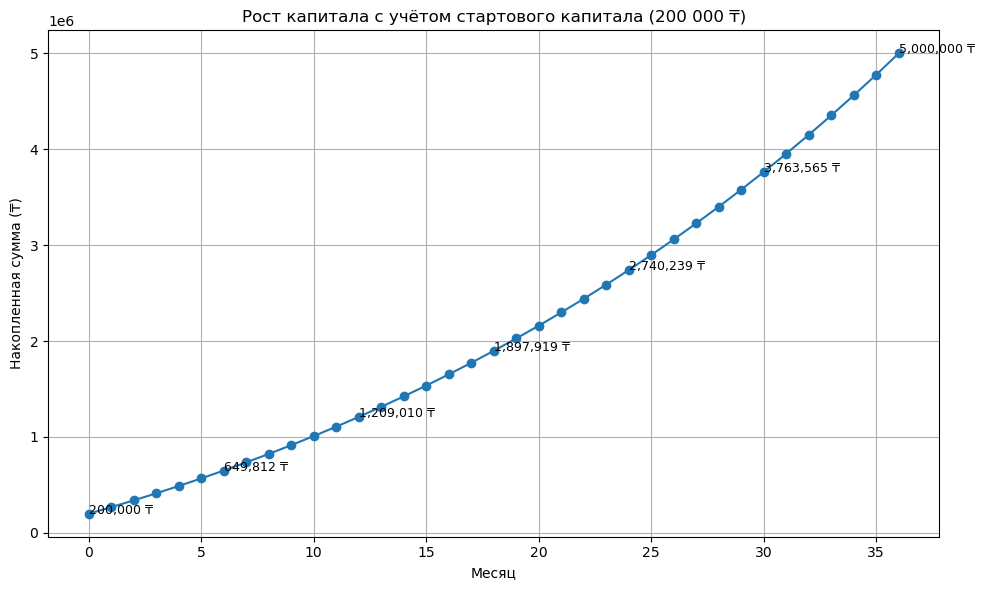

In [31]:
# Создание графика накоплений с учётом стартового капитала
# Список накопленных сумм по месяцам (включая месяц 0)
cumulative_sums_with_initial = [initial_capital]
for month in range(1, months + 1):
    cumulative_sum = (
        initial_capital * ((1 + weighted_return) ** (month / 12)) +
        required_monthly_investment_with_initial * month * ((1 + weighted_return) ** (month / 12))
    )
    cumulative_sums_with_initial.append(cumulative_sum)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(range(0, months + 1), cumulative_sums_with_initial, marker='o')
plt.title("Рост капитала с учётом стартового капитала (200 000 ₸)")
plt.xlabel("Месяц")
plt.ylabel("Накопленная сумма (₸)")
plt.grid(True)

# Добавим значения на график каждые 6 месяцев
for i in range(0, months + 1, 6):
    plt.text(i, cumulative_sums_with_initial[i], f"{cumulative_sums_with_initial[i]:,.0f} ₸", fontsize=9)

plt.tight_layout()
plt.show()


In [23]:
# Добавим нулевой месяц с начальным капиталом без инвестиций
investment_data_with_initial_zero = pd.concat([
    pd.DataFrame({
        "Month": [0],
        "Monthly Investment (₸)": [0.0],
        "Cumulative Value (₸)": [initial_capital]
    }),
    investment_data_with_initial
], ignore_index=True)

investment_data_with_initial_zero


,Month,Monthly Investment (₸),Cumulative Value (₸)
0,0,0.00,200000.00
1,1,68484.83,273810.16
2,2,68484.83,350469.66
3,3,68484.83,430062.47
4,4,68484.83,512674.82
5,5,68484.83,598395.16
6,6,68484.83,687314.29
7,7,68484.83,779525.38
8,8,68484.83,875124.03
9,9,68484.83,974208.36


In [15]:
# Импорт библиотек
import pandas as pd
import numpy as np

# Пути к CSV-файлам с историческими данными
files = {
    'KEGC': "datasets_final\KZ\HistoricalData_KEGC.csv",
    'KSPI': "datasets_final\KZ\HistoricalData_KSPI.csv",
    'KMGZ': "datasets_final\KZ\HistoricalData_KMGZ.csv",
    'KZAP': "datasets_final\KZ\HistoricalData_KZAP.csv"
}

# Функция расчёта годовой доходности
def calculate_annual_return_cleaned(file_path):
    df = pd.read_csv(file_path)
    df = df.dropna()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df['Price'] = df['Price'].replace(',', '', regex=True)
    df['Price'] = df['Price'].replace(r'[^\d.]', '', regex=True).astype(float)
    start_price = df.iloc[0]['Price']
    end_price = df.iloc[-1]['Price']
    num_years = (df.iloc[-1]['Date'] - df.iloc[0]['Date']).days / 365.25
    if num_years == 0:
        return None
    return (end_price / start_price) ** (1 / num_years) - 1

# Вычисляем доходности
expected_annual_returns = {}
for symbol, path in files.items():
    ret = calculate_annual_return_cleaned(path)
    if ret is not None:
        expected_annual_returns[symbol] = ret

# Параметры инвестора
monthly_investment = 50_000
months = 36
target_goal = 5_000_000
initial_capital = 200_000

symbols = list(expected_annual_returns.keys())
expected_returns_array = np.array([expected_annual_returns[symbol] for symbol in symbols])

# PSO настройки
n_particles = 30
n_iterations = 100
dimensions = len(symbols)
w, c1, c2 = 0.5, 1.5, 1.5

particles = np.random.rand(n_particles, dimensions)
velocities = np.random.rand(n_particles, dimensions) * 0.1

# Целевая функция с учётом стартового капитала
def pso_objective(weights):
    weights = np.array(weights)
    weights /= weights.sum()
    weighted_return = np.dot(weights, expected_returns_array)
    future_value = (
        initial_capital * ((1 + weighted_return) ** 3) +
        monthly_investment * months * ((1 + weighted_return) ** 3)
    )
    return abs(target_goal - future_value)

# Запуск PSO
personal_best_positions = particles.copy()
personal_best_scores = np.array([pso_objective(p) for p in particles])
global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
global_best_score = personal_best_scores.min()

for _ in range(n_iterations):
    for i in range(n_particles):
        r1, r2 = np.random.rand(), np.random.rand()
        velocities[i] = (
            w * velocities[i] +
            c1 * r1 * (personal_best_positions[i] - particles[i]) +
            c2 * r2 * (global_best_position - particles[i])
        )
        particles[i] += velocities[i]
        particles[i] = np.clip(particles[i], 0, 1)
        score = pso_objective(particles[i])
        if score < personal_best_scores[i]:
            personal_best_scores[i] = score
            personal_best_positions[i] = particles[i].copy()
            if score < global_best_score:
                global_best_score = score
                global_best_position = particles[i].copy()

# Финальное распределение
final_weights_pso = global_best_position / global_best_position.sum()
portfolio_allocation = dict(zip(symbols, final_weights_pso))

# Получаем последние цены акций
def get_latest_price(file_path):
    df = pd.read_csv(file_path)
    df = df.dropna()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df['Price'] = df['Price'].replace(',', '', regex=True)
    df['Price'] = df['Price'].replace(r'[^\d.]', '', regex=True).astype(float)
    return df.iloc[-1]['Price']

latest_prices = {symbol: get_latest_price(path) for symbol, path in files.items()}

# Формируем таблицу покупки акций
stock_purchase_table = []
for symbol in symbols:
    share = portfolio_allocation[symbol]
    allocated_money = monthly_investment * share
    price = latest_prices[symbol]
    quantity = int(allocated_money // price)
    spent = quantity * price
    stock_purchase_table.append({
        "Symbol": symbol,
        "Latest Price (₸)": round(price, 2),
        "Portfolio Share (%)": round(share * 100, 2),
        "Allocated (₸)": round(allocated_money, 2),
        "Quantity to Buy": quantity,
        "Total Spent (₸)": round(spent, 2),
        "Total Quantity in Portfolio": quantity * months,
        "Remaining Cash (₸)": round(monthly_investment - spent, 2)
    })
purchase_df = pd.DataFrame(stock_purchase_table)

purchase_df


,Symbol,Latest Price (₸),Portfolio Share (%),Allocated (₸),Quantity to Buy,Total Spent (₸),Total Quantity in Portfolio,Remaining Cash (₸)
0,KEGC,1482.00,0.0,0.0,0,0.00,0,50000.00
1,KSPI,49800.00,0.0,0.0,0,0.00,0,50000.00
2,KMGZ,14498.99,50.0,25000.0,1,14498.99,36,35501.01
3,KZAP,18995.00,50.0,25000.0,1,18995.00,36,31005.00


In [19]:
# Объединённый пересчёт с учётом того, что обе акции входят в портфель
# и остаток рассчитывается от общего вложения (50 000 - сумма на все акции)

# Переподготовка таблицы с учётом новых условий
selected_stocks = [s for s in symbols if portfolio_allocation[s] > 0]
investment_per_month = monthly_investment

# Формируем таблицу покупки акций
stock_purchase_table = []
total_spent = 0

for symbol in selected_stocks:
    share = portfolio_allocation[symbol]
    allocated_money = investment_per_month * share
    price = latest_prices[symbol]
    quantity = int(allocated_money // price)
    spent = quantity * price
    total_spent += spent
    stock_purchase_table.append({
        "Symbol": symbol,
        "Latest Price (₸)": round(price, 2),
        "Portfolio Share (%)": round(share * 100, 2),
        "Allocated (₸)": round(allocated_money, 2),
        "Quantity to Buy": quantity,
        "Total Spent (₸)": round(spent, 2),
        "Total Quantity in Portfolio": quantity * months
    })

# Рассчитываем остаток как разницу от общей суммы 50 000
remaining_cash = round(investment_per_month - total_spent, 2)
for row in stock_purchase_table:
    row["Remaining Cash (₸)"] = remaining_cash

# Итоговая таблица
purchase_df = pd.DataFrame(stock_purchase_table)
purchase_df


,Symbol,Latest Price (₸),Portfolio Share (%),Allocated (₸),Quantity to Buy,Total Spent (₸),Total Quantity in Portfolio,Remaining Cash (₸)
0,KMGZ,14498.99,50.0,25000.0,1,14498.99,36,16506.01
1,KZAP,18995.00,50.0,25000.0,1,18995.00,36,16506.01


In [23]:
# Обновлённая логика: остаток будет использован для покупки ещё одной акции, если его хватает

# Повторим распределение 50/50 для KMGZ и KZAP
custom_allocation = {
    'KMGZ': 0.5,
    'KZAP': 0.5
}

# Перерасчёт покупки с возможностью докупить за остаток
custom_stock_purchase_table = []
total_spent = 0
symbol_data = {}

# Основная покупка
for symbol in custom_allocation:
    share = custom_allocation[symbol]
    allocated = monthly_investment * share
    price = latest_prices[symbol]
    qty = int(allocated // price)
    spent = qty * price
    total_spent += spent
    symbol_data[symbol] = {
        "Symbol": symbol,
        "Price": price,
        "Allocated": allocated,
        "Qty": qty,
        "Spent": spent
    }

# Остаток после основных покупок
remaining_cash = monthly_investment - total_spent

# Попробуем купить ещё одну акцию, если хватает остатка
for symbol in symbol_data:
    price = symbol_data[symbol]["Price"]
    if remaining_cash >= price:
        symbol_data[symbol]["Qty"] += 1
        symbol_data[symbol]["Spent"] += price
        remaining_cash -= price
        break  # покупаем только одну доп. акцию (приоритет у первой подходящей)

# Финальный сбор таблицы
for data in symbol_data.values():
    custom_stock_purchase_table.append({
        "Symbol": data["Symbol"],
        "Latest Price (₸)": round(data["Price"], 2),
        "Portfolio Share (%)": round(custom_allocation[data["Symbol"]] * 100, 2),
        "Allocated (₸)": round(data["Allocated"], 2),
        "Quantity to Buy": data["Qty"],
        "Total Spent (₸)": round(data["Spent"], 2),
        "Total Quantity in Portfolio": data["Qty"] * months,
        "Remaining Cash (₸)": round(remaining_cash, 2)
    })

custom_purchase_df = pd.DataFrame(custom_stock_purchase_table)

custom_purchase_df


,Symbol,Latest Price (₸),Portfolio Share (%),Allocated (₸),Quantity to Buy,Total Spent (₸),Total Quantity in Portfolio,Remaining Cash (₸)
0,KMGZ,14498.99,50.0,25000.0,2,28997.98,72,2007.02
1,KZAP,18995.00,50.0,25000.0,1,18995.00,36,2007.02


## Настроение рынка (Спидометр)

In [37]:
# Re-import necessary libraries after code execution state reset
import pandas as pd
import numpy as np

# Define file paths again
file_paths = [
    "datasets_final\HistoricalData_KEGC.csv",
    "datasets_final\HistoricalData_KSPI.csv",
    "datasets_final\HistoricalData_KMGZ.csv",
    "datasets_final\HistoricalData_KZAP.csv"
]

# Volume parsing function
def parse_volume(vol_str):
    if isinstance(vol_str, str):
        if 'K' in vol_str:
            return float(vol_str.replace('K', '')) * 1_000
        elif 'M' in vol_str:
            return float(vol_str.replace('M', '')) * 1_000_000
    return pd.to_numeric(vol_str, errors='coerce')

# Preprocess stock data
def preprocess_stock_data(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] <= pd.Timestamp("2025-02-26")]
    df['Vol.'] = df['Vol.'].apply(parse_volume)
    df[['Price', 'Open', 'High', 'Low']] = df[['Price', 'Open', 'High', 'Low']].apply(pd.to_numeric, errors='coerce')
    df.sort_values(by='Date', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Load and preprocess all stock datasets
stock_dfs = [preprocess_stock_data(fp) for fp in file_paths]

# Compute sentiment indicators
sentiment_data = []

for df in stock_dfs:
    df['Price Change %'] = df['Price'].pct_change(-1) * 100
    df['Volume Change %'] = df['Vol.'].pct_change(-1) * 100
    df['Volatility'] = (df['High'] - df['Low']) / df['Open']

    row = df[df['Date'] == pd.Timestamp("2025-02-26")]
    if not row.empty:
        sentiment_data.append({
            "Date": "2025-02-26",
            "Price Change %": row['Price Change %'].values[0],
            "Volume Change %": row['Volume Change %'].values[0],
            "Volatility": row['Volatility'].values[0]
        })

# Create a DataFrame
sentiment_df = pd.DataFrame(sentiment_data)

# Normalize function
def normalize_column(series, invert=False):
    norm = (series - series.min()) / (series.max() - series.min()) * 100
    return 100 - norm if invert else norm

# Normalize and calculate sentiment index
sentiment_df['Price Index'] = normalize_column(sentiment_df['Price Change %'])
sentiment_df['Volume Index'] = normalize_column(sentiment_df['Volume Change %'])
sentiment_df['Volatility Index'] = normalize_column(sentiment_df['Volatility'], invert=True)

sentiment_df['Sentiment Index'] = sentiment_df[['Price Index', 'Volume Index', 'Volatility Index']].mean(axis=1)

# Return average sentiment index across all stocks
market_sentiment_26_feb = sentiment_df['Sentiment Index'].mean()
market_sentiment_26_feb


C:\Users\altyb\AppData\Local\Temp\ipykernel_18260\2331648473.py:41: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Price Change %'] = df['Price'].pct_change(-1) * 100
C:\Users\altyb\AppData\Local\Temp\ipykernel_18260\2331648473.py:41: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Price Change %'] = df['Price'].pct_change(-1) * 100
C:\Users\altyb\AppData\Local\Temp\ipykernel_18260\2331648473.py:41: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or s

33.83949945942392